In [215]:
## 2024 aPC flavor & hedonic testing

## import packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import pandas as pd
import sys
from BaselineRemoval import BaselineRemoval
import pynapple as nap
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'retina'

import sys
import os


/opt/anaconda3/envs/pynapple/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


In [216]:
## plotting settings

## create color map
my_color_map = ['#56b4e9',
                '#e69f00',
                '#009e73',
                '#f0e442',
                '#0072b2',
                '#d55e00',
                '#cc79a7']
# convert to sns plotting rgb
my_color_map = sns.color_palette(my_color_map)


## font setting
plt.rcParams["font.family"] = 'Arial'
plt.rcParams.update({'font.size': 8})


In [217]:
### function block, need to move to "binge.py" later, but will keep them here

##### functions for data processing #####

## burst detection function from other ppl, adapted from the following link
## https://spikesandbursts.wordpress.com/2023/08/24/patch-clamp-data-analysis-in-python-bursts/
def burst_detection(df, spike_times,
                    n_spikes, 
                    max_isi, 
                    # min_duration,  # Optional
                    min_ibi):
     
    """
    Detects bursts in spike data based on spike times, 
    by identifying consecutive spikes that fulfill the criteria of:
    minimum number of spikes, maximum interspike interval, and minimum interburst interval.
     
    Arguments: 
        df: DataFrame with spike data.
        spike_times: Column name for spike positions.
        spike_amplitudes: Column name for spike amplitudes.
        spike_peaks: Column name for spike peak amplitudes. 
        n_spikes: Minimum number of spikes within a burst.
        max_isi: Max interspike interval within the burst.
        min_duration: Minimum burst duration.
        min_ibi: Minimum interburst interval (optional).
         
    Returns:
        DataFrame with burst information.
    """
     
    df = df.sort_values(by=spike_times)  # Sort DataFrame by spike positions
    df['burst'] = np.nan  # Create column for burst labels
    burst_num = 0        # Initialize burst number
    burst_start = None   # Initialize burst start position
    last_spike = None    # Initialize last spike position
 
    for i, row in df.iterrows():  # Loop through DataFrame rows 
        spike = row[spike_times]   # Extract the spike position 
         
        if burst_start is None:   # It checks if it is the first spike 
            burst_start = spike   # It marks the current spike position as the start of a burst
            last_spike = spike    # Update the last_spike position to the current spike position
            df.at[i, 'burst'] = burst_num   # Assign burst number
        elif spike - last_spike <= max_isi:  # It checks if the current spike is within max isi
            df.at[i, 'burst'] = burst_num  
            last_spike = spike 
        elif spike - last_spike > min_ibi:  # It checks if the interburst interval has been reached
            burst_num += 1 
            burst_start = spike 
            last_spike = spike  
            df.at[i, 'burst'] = burst_num
     
    # Filter bursts with less than min_spikes
    df = df[df.groupby('burst')[spike_times].transform('count') >= n_spikes]
     
    # Filter burst shorter that min_duration (min_duration parameter)
    # df = df[df.groupby('burst')[spike_times].transform('max') 
    #         - df.groupby('burst')[spike_times].transform('min')
    #         >= min_duration]
     
    # Calculate burst information by aggregating single spike information
    bursts = df.groupby('burst')[spike_times].agg(['min', 'max', 'count'])
    bursts.columns = ['burst_start', 'burst_end', 'spikes_in_bursts']
    bursts['burst_length'] = bursts['burst_end'] - bursts['burst_start']
    # bursts['avg_spike_amplitude'] = df.groupby('burst')[spike_amplitudes].mean()
    # bursts['avg_spike_peaks'] = df.groupby('burst')[spike_peaks].mean()  
    bursts['spikes_frequency'] = bursts['spikes_in_bursts'] / bursts['burst_length']
    bursts = bursts.reset_index()
    bursts['burst_number'] = bursts.index + 1
     
    return bursts[['burst_number', 'burst_start', 'burst_end', 
                   'burst_length', 'spikes_in_bursts', 'spikes_frequency']]

## new detection function that used the above function
def detect_binge_bout(Pump_event, n_pumps, max_isi, min_ibi):
    df = pd.DataFrame(Pump_event,columns=['spike_times'])
    binge_df = burst_detection(df=df,spike_times='spike_times', 
                             n_spikes = n_pumps,  
                             max_isi = max_isi,
                             min_ibi = min_ibi)
    binge_df = binge_df.rename(columns={"burst_number":"binge_bout_idx",
                                    "burst_start":"start",
                                    "burst_end":"end",
                                    "burst_length":"bout_duration",
                                    "spikes_in_bursts":"deliveries_in_bout",
                                    "spikes_frequency":"delivery_frequency"})
    
    return binge_df, nap.IntervalSet(start= binge_df['start'],end=binge_df['end'])

def slow_feeding_event_clean_up(slow_milk_ts, lick_event):
    slow_milk_ts_clean  = np.array([t for t in slow_milk_ts if (lick_event[lick_event>t][0]-t) <4]) # check there is lick event after the delivery in 4 sec
    slow_milk_ts_clean = np.pad(slow_milk_ts_clean,(0,1),'constant', constant_values=(4000,))
    slow_milk_ts_clean = np.sort(slow_milk_ts_clean)
    slow_milk_ts_clean  = np.array([x for x,y in zip(slow_milk_ts_clean[:-1],slow_milk_ts_clean[1:]) if (y-x) > 3.5]) # exclude slow feeding events that come from incomplete binge feeding
    return slow_milk_ts_clean


## downsample Ca2+ data to 10 Hz all together for easier processing afterward?
def downsample(df_accepted):
    ## add a condition here to check if it's already 10 hz
    from math import isclose
    a = df_accepted.index[1]-df_accepted.index[0] # get diff
    b = 0.05
    print(f'frame diff: {round(a,5)}')
    if isclose(a, b, abs_tol=1e-3):
        print('20 Hz -> 10 Hz')
        # if df_accepted.index[1]-df_accepted.index[0]
        from scipy import signal
        sample_num = int(df_accepted.shape[0]/2)
        df_downsampled =  pd.DataFrame(signal.resample(df_accepted, sample_num),index=df_accepted.index[::2][0:sample_num],columns=df_accepted.columns)
        return df_downsampled
    else:
        print('already 10 Hz')
        return df_accepted


def get_PETH_dict(df_accepted,slow_milk_ts_clean):
    ## now generate PSTH for each cell
    windowsize = 10 # sec, before + after
    half_window = int(windowsize/2)
    num_bins = windowsize * 10 # based on 10 Hz
    # t_scale = np.linspace(-5,5,num_bins)
    PETH_trace_milk = {} 

    cellset = df_accepted.columns
    for cell in cellset:
        PETH_trace = np.zeros([len(slow_milk_ts_clean),num_bins])
        for trial, time in enumerate(slow_milk_ts_clean):
            value = df_accepted[cell][time-half_window:time+half_window].values

            while len(value)<100:
                print(trial,time)
                print('add nan to last part')
                value = np.pad(value, (0, 1), 'constant', constant_values=(np.nan,np.nan))
            else:
                PETH_trace[trial,:] = value[0:num_bins] # keep the slicer here so in case we got one more value here
        PETH_trace_milk[cell] = PETH_trace
    return PETH_trace_milk


def get_PETH_binge(df_accepted,binge_epoch):
    ## now generate PSTH for each cell
    windowsize = 10 # sec, before + after
    half_window = int(windowsize/2)
    num_bins = windowsize * 10 # based on 10 Hz
    # t_scale = np.linspace(-5,5,num_bins)
    PETH_trace_binge_on = {} 
    PETH_trace_binge_off = {}

    cellset = df_accepted.columns

    for cell in cellset:
        PETH_trace = np.zeros([binge_epoch.shape[0],num_bins])
        for trial, time in enumerate(binge_epoch['start']):
            value = df_accepted[cell][time-half_window:time+half_window].values
            while len(value)<100:
                print(trial,time)
                print('add nan to last part')
                value = np.pad(value, (0, 1), 'constant', constant_values=(np.nan,np.nan))
            else:
                PETH_trace[trial,:] = value[0:num_bins] # keep the slicer here so in case we got one more value here
        PETH_trace_binge_on[cell] = PETH_trace

        PETH_trace = np.zeros([binge_epoch.shape[0],num_bins])
        for trial, time in enumerate(binge_epoch['end']):
            value = df_accepted[cell][time-half_window:time+half_window].values
            while len(value)<100:
                print(trial,time)
                print('add nan to last part')
                value = np.pad(value, (0, 1), 'constant', constant_values=(np.nan,np.nan))
            else:
                PETH_trace[trial,:] = value[0:num_bins] # keep the slicer here so in case we got one more value here
        PETH_trace_binge_off[cell] = PETH_trace
    return PETH_trace_binge_on,PETH_trace_binge_off

## align baseline to 0 for individual trial
def baseline_correct(PETH, window=1):
    for key in PETH.keys():
        matrix = PETH.get(key)
        for trial in range(matrix.shape[0]):
            matrix[trial,:] -= np.mean(matrix[trial,50-int(window*10):50]) # baseline mean centered (1 sec before event time)
        PETH[key] = matrix
    return PETH


def correct_baseline_modploy(df_accepted):
    """
    This is used for correcting bleaching on NM imaging
    """
    df_corrected = pd.DataFrame(index=df_accepted.index)
    for idx,col in enumerate(df_accepted.columns):
        input_array = df_accepted[col].values
        polynomial_degree=2 #only needed for Modpoly and IModPoly algorithm
        baseObj=BaselineRemoval(input_array)
        Modpoly_output=baseObj.ModPoly(polynomial_degree)
        # df_corrected = pd.DataFrame(data=Modpoly_output,index=df_accepted.index,columns=[' C1'])
        df_corrected[f' C{idx}'] = Modpoly_output
    return df_corrected

#### lick event related ####

def load_lick_event(file_path):
    # dat = load_npy()
    dat = np.load(file_path, allow_pickle=True)
    PETH_lick_binge  = dat.item().get('PETH_lick_binge')
    PETH_lick_slow   = dat.item().get('PETH_lick_slow')
    PETH_lick_slow_single = dat.item().get('PETH_lick_slow_single')
    return PETH_lick_binge,PETH_lick_slow,PETH_lick_slow_single

def lick_df_sns(PETH_lick_binge_concat):
    PETH_lick_binge_concat_sns = PETH_lick_binge_concat.T.reset_index().melt(value_name='Lick',var_name='Time (sec)',id_vars='index')
    PETH_lick_binge_concat_sns = PETH_lick_binge_concat_sns.rename(columns={'index':'Trial'})
    return  PETH_lick_binge_concat_sns


def load_peth_pump_event(file_path):
    dat = np.load(file_path, allow_pickle=True)
    PETH_pump_binge  = dat.item().get('PETH_pump_binge')
    PETH_pump_slow   = dat.item().get('PETH_pump_slow')
    return PETH_pump_binge,PETH_pump_slow

def pump_df_sns(PETH_lick_binge_concat):
    PETH_lick_binge_concat_sns = PETH_lick_binge_concat.T.reset_index().melt(value_name='Pump delivery',var_name='Time (sec)',id_vars='index')
    PETH_lick_binge_concat_sns = PETH_lick_binge_concat_sns.rename(columns={'index':'Trial'})
    return  PETH_lick_binge_concat_sns

def deco_scale(data,**kws):
    ax = plt.gca()
    ax.set_yticks([0,5,10])
    ax.set_xlabel('Time from feeding onset (sec)',labelpad=10)
    sns.despine()
    ax.set_xlim(xmin=-3)


In [218]:
def datetime_convert_phenosys(csv_path):
    ## Def phensys converter for lick rate
    def timestampconvert(x):
        stamp = datetime.timedelta(days = x)
        result = datetime.datetime(1899,12,30,0,0) + stamp
        # print(result.strftime('%Y-%m-%d %H:%M:%S.%f'))
        return result
    
    df_pheno = pd.read_csv(csv_path,sep=',')
    time_list = df_pheno['DateTime']
    result = []
    for x in time_list:
        timestampconvert(float(x))
        result.append(timestampconvert(x))
    new_time_stamps = []
    for i in result:
        new_time_stamps.append((i-min(result)).total_seconds())
    df_pheno = df_pheno.fillna(0)
    df_pheno['DateTime'] = new_time_stamps
    # df_pheno
    return df_pheno

## Function for getting Pump events
def Pump_event_calculate_P1_all(csv_path):
    """
    This function will calcuate the lick sensor data from the phenosys csv files and return 3 lists of timestamps from GPIOs P1 and P1C and the timestamps of both channels.

    """
    df = datetime_convert_phenosys(csv_path)
    
    # Get L1 timestamps and MsgValue1
    P1_time = df[df['unitLabel']=='P1']['DateTime'].values
    P1_time = P1_time[P1_time>299]
    P1C_time = df[df['unitLabel']=='P1C']['DateTime'].values
    P1C_time = P1C_time[P1C_time>299]
    P1D_time = df[df['unitLabel']=='P1D']['DateTime'].values 
    P1D_time = P1D_time[P1D_time>299]

    # all_pump_events = P1_time + P1C_time + P2_time + P2A_time
    Pump_all = np.concatenate([P1_time,P1C_time,P1D_time],axis=0)
    Pump_all = sorted(Pump_all)
    Pump_all = np.array(Pump_all)
    
    return P1_time, P1C_time, P1D_time, Pump_all


## Function for getting L1 and L2 lick events
def lick_event_calculate(csv_path):
    """
    This function will calcuate the lick sensor data from the phenosys csv files and return 3 lists of timestamps from sensor L1, L2 and the timestamps of both channels. It will also do a quick plotting for the lick sensor data for raster plots and the density plot of overall lick events.

    """
    df = datetime_convert_phenosys(csv_path)
    
    # Get L1 timestamps and MsgValue1
    L1_time = df[df['unitLabel']=='L1']['DateTime'].values
    L1_value = df[df['unitLabel']=='L1']['MsgValue1'].values
    L1_timestamps_new = []

    # loop through each L1 value, if it has more than 1 value meaning more licks are packed here
    for idx,value in enumerate(L1_value):
        # check if >1 licks are packed in this row
        if len(value.split(','))>1:
            # loop through individual licks packed in this row
            for idx_j,j in enumerate(value.split(',')):
                if idx_j == 0:
                    # get time from L1_time[idx] directly since this is the first lick
                    L1_timestamps_new.append(L1_time[idx])
                else:
                    # get the first value of the lick events, meaning the time difference since the last lick "onset", note it's not the gap between these 2 lick events
                    individual_value = int(j.split('-')[0])*0.001 # convert ms to s
                    # add the time difference (individual_value) to the last timestamp in the array (last lick timestamp)
                    L1_timestamps_new.append(L1_timestamps_new[-1]+individual_value)
        else:
            # only 1 lick event in this row, directly save the timestamp
            L1_timestamps_new.append(L1_time[idx])
    L1_timestamps_new = np.array(L1_timestamps_new)

    ## The same for L2
    L2_time = df[df['unitLabel']=='L2']['DateTime'].values
    L2_value = df[df['unitLabel']=='L2']['MsgValue1'].values
    L2_timestamps_new = []
    
    # loop through each L1 value, if it has more than 1 value meaning more licks are packed here
    for idx,value in enumerate(L2_value):
        # check if >1 licks are packed in this row
        if len(value.split(','))>1:
            # loop through individual licks packed in this row
            for idx_j,j in enumerate(value.split(',')):
                if idx_j == 0:
                    # get time from L1_time[idx] directly since this is the first lick
                    L2_timestamps_new.append(L2_time[idx])
                else:
                    # get the first value of the lick events, meaning the time difference since the last lick "onset", note it's not the gap between these 2 lick events
                    individual_value = int(j.split('-')[0])*0.001 # convert ms to s
                    # add the time difference (individual_value) to the last timestamp in the array (last lick timestamp)
                    L2_timestamps_new.append(L2_timestamps_new[-1]+individual_value)
        else:
            # only 1 lick event in this row, directly save the timestamp
            L2_timestamps_new.append(L2_time[idx])
    L2_timestamps_new = np.array(L2_timestamps_new)

    all_lick_events = np.array(sorted([*L1_timestamps_new,*L2_timestamps_new]))

    return L1_timestamps_new, L2_timestamps_new, all_lick_events

In [219]:
## load inscopix & phenosys data

mouse_id = 'DSC024437' # local TuS recording

date = '240904' # 0822/23/27/28/29/30/0902/03/04 for straw ensure vs water
# date = '240826' # 08/26 for straw/choco/water

date_with_dot = '.'.join(date[i:i+2] for i in range(0, len(date), 2))

## set up a dictionary for what solutions are given to the mice on each day
if date in ['240822','240823','240827','240828','240829','240830']:
    flavor_dict = {'P1D':'Strawberry Ensure',
                    'P1C':'Water',                   
                    'P1':'Empty'}
elif date in ['240826']:
    flavor_dict = {'P1D':'Strawberry Ensure',
                   'P1C':'Chocolate Ensure',
                   'P1':'Water'}
elif date in ['240902','240903','240904','240905']:
    flavor_dict = {'P1D':'Strawberry Ensure',
                   'P1C':'Diluted Ensure',
                   'P1':'Water'}

csv_folder = '/Users/hunglo/Documents/inscopix_csv/2024_TuS/'

## load phenosys
phenosys_file = os.path.join(csv_folder,'phenosys_csv',f'{mouse_id}_Inscopix-{date_with_dot}_.csv')
## load inscopix csv
ca2_csv_file = os.path.join(csv_folder,'ca2_csv',f'{mouse_id}{date}_celltraces.csv')
GPIO_csv_file = os.path.join(csv_folder,'ca2_csv',f'{mouse_id}{date}_GPIO.csv')

print(flavor_dict)
print(f'{phenosys_file = }')
print(f'{ca2_csv_file = }')
print(f'{GPIO_csv_file = }')


{'P1D': 'Strawberry Ensure', 'P1C': 'Diluted Ensure', 'P1': 'Water'}
phenosys_file = '/Users/hunglo/Documents/inscopix_csv/2024_TuS/phenosys_csv/DSC024437_Inscopix-24.09.04_.csv'
ca2_csv_file = '/Users/hunglo/Documents/inscopix_csv/2024_TuS/ca2_csv/DSC024437240904_celltraces.csv'
GPIO_csv_file = '/Users/hunglo/Documents/inscopix_csv/2024_TuS/ca2_csv/DSC024437240904_GPIO.csv'


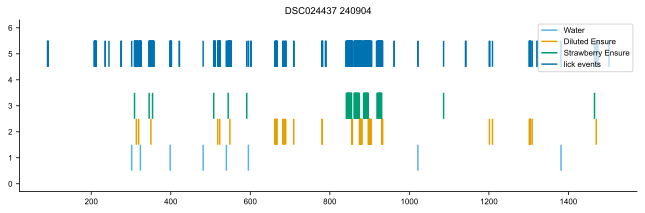

In [220]:
P1_time, P1C_time, P1D_time, Pump_all = Pump_event_calculate_P1_all(phenosys_file)

L1_timestamps_new, L2_timestamps_new, all_lick_events = lick_event_calculate(phenosys_file)

plt.figure(figsize=[9,3])
plt.title(f"{mouse_id} {date}")
plt.eventplot(P1_time,color=my_color_map[0],label=flavor_dict['P1'])
plt.eventplot(P1C_time,lineoffsets=2,color=my_color_map[1],label=flavor_dict['P1C'])
plt.eventplot(P1D_time,lineoffsets=3,color=my_color_map[2],label=flavor_dict['P1D'])
# plt.eventplot(Pump_all,lineoffsets=4,color=my_color_map[3],label='all_pump_events')

plt.eventplot(L1_timestamps_new,lineoffsets=5,color=my_color_map[4],label='lick events')

plt.legend()
sns.despine()
plt.tight_layout()


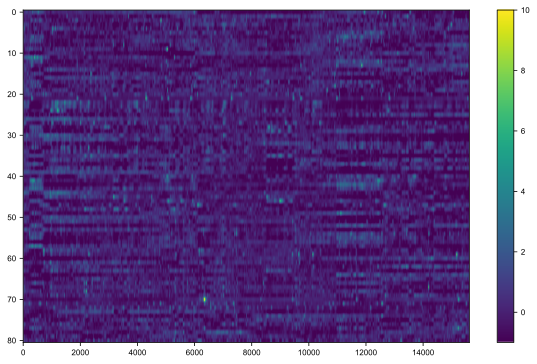

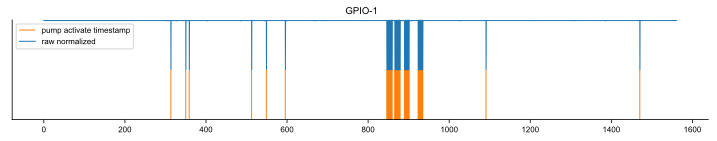

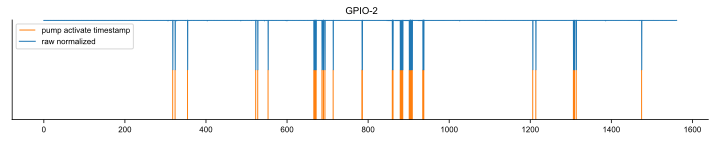

time difference: 4.521000000000001
time_difference = -4.521000000000001


In [179]:
## load Ca2+ csv

df_all = pd.read_csv(ca2_csv_file,header=[0,1],index_col=0)
df_accepted = df_all.xs(' accepted',level='Time(s)/Cell Status',axis=1)
# df_accepted
# df_accepted = correct_baseline_modploy(df_accepted)

from scipy import stats
df_z = df_accepted.apply(stats.zscore,axis=0)

vmax,vmin=10,-1

plt.figure(figsize=[10,6])
plt.imshow(df_z.T,aspect='auto',vmax=vmax,vmin=vmin)
plt.colorbar()

df_GPIO = df_GPIO = pd.read_csv(GPIO_csv_file, header=[0], index_col=0)

def extract_GPIO_trace(df_GPIO,plot=False):
    """
    Extract GPIO traces and binarized them to timestamps
    """
    GPIO_channel_list = [name for name in df_GPIO[' Channel Name'].unique() if 'IO' in name]
    ## this should extract both GPIO or IO prefix in difference nVista system
    gpio_pump_time_all = {}
    for channel in GPIO_channel_list:
        gpio_value = df_GPIO.loc[df_GPIO[' Channel Name'] == channel][' Value'].astype(float)
        # print(channel)
        ## check if there is signal at all
        if gpio_value.max()/(gpio_value.min()+1e-8) > 2: # prevent min is 0
            gpio_norm = (gpio_value-gpio_value.min())/(gpio_value.max()-gpio_value.min())
            gpio_timestamps = np.concatenate([np.zeros(1),gpio_norm[gpio_norm<0.5].index],axis=0)
            gpio_time_diff = np.diff(gpio_timestamps)
            gpio_pump_time = gpio_timestamps[1:][gpio_time_diff>0.04]
            gpio_pump_time_all[channel] = gpio_pump_time
            # print(f'First pump time: {gpio_pump_time_all[channel][0]}')

            if plot:
                plt.figure(figsize=[10,2])
                plt.title(channel)
                plt.eventplot(gpio_pump_time_all[channel],colors='C1',lineoffsets=-0.5,linewidths=1,label='pump activate timestamp')
                plt.plot(gpio_norm,lw=1,label='raw normalized')
                plt.legend()
                plt.yticks([])
                plt.ylim([-1,1])
                sns.despine()
                plt.tight_layout()
                # plt.xlim([300,350])
                # plt.xlim([410,420])
                plt.show()
        else:
            # print(f'No inputs in{channel} channel, skipped\n')
            # print(channel)
            pass
    ## Check if GPIO signals are missing, if so add an empty np array to the corresponding channel:
    # print(f'chan #{len(gpio_pump_time_all.keys())}')
    if len(gpio_pump_time_all.keys())==1:
        if ' GPIO-1' in gpio_pump_time_all.keys():
            gpio_pump_time_all[' GPIO-2'] = np.array([])
        elif ' IO1' in gpio_pump_time_all.keys():
            gpio_pump_time_all[' IO2'] = np.array([])
        elif ' IO2' in gpio_pump_time_all.keys():
            gpio_pump_time_all[' IO1'] = np.array([])
        elif ' GPIO-3' in gpio_pump_time_all.keys():
            gpio_pump_time_all[' GPIO-4'] = np.array([])
    ## simplify GPIO channel to just GPIO1 & 2
    keys = gpio_pump_time_all.keys()
    # print(f'chan #{len(gpio_pump_time_all.keys())}')
    # GPIO_pool = []
    for idx,key in enumerate(keys):
      # print(idx,key)
      # print(gpio_pump_time_all.get(key))
    #   GPIO_pool.append(np.min(gpio_pump_time_all[key]))
      if idx ==0:
        GPIO_pump1 = gpio_pump_time_all[key]
      else:
        GPIO_pump2 = gpio_pump_time_all[key]
    GPIO_pump1_clean, GPIO_pump2_clean, GPIO_pump_all_no_init = remove_isx_GPIO_init(GPIO_pump1,GPIO_pump2)
    # GPIO_min = np.min(GPIO_pump_all_no_init)
    # print(len(GPIO_pump1_clean), len(GPIO_pump2_clean))

    return GPIO_pump1_clean, GPIO_pump2_clean, GPIO_pump_all_no_init

def remove_isx_GPIO_init(Pump1,Pump2):
  pump_all = [*Pump1,*Pump2]
  pump_all = sorted(pump_all)
  ## remove all pump event in 300 sec, since there shouldn't be any
  pump_all = [i for i in pump_all if i >= 300]
  pump_all = np.array(pump_all)
  x_shift_end = pump_all[-1]
  x_shift_start = pump_all[0] -120 # force the x_bar to start at the beginning of this round
  x_bar = [x*180+300 for x in range(18)]
  # x_bar = [0] + x_bar
  x_bar = np.array(x_bar)
  x_bar = x_bar[x_bar<x_shift_end]
  x_bar = x_bar[x_bar>x_shift_start]
  Pump1 = np.array(Pump1)
  Pump2 = np.array(Pump2)
  for x in x_bar:
    if find_nearest(pump_all[pump_all>x],x)-x>25: # this means there is no initial pulse within 3 sec at the round starting time
       pass
    else:
      if len(Pump2[Pump2>x]) == 0: ## prevent the 2nd pump is empty
        if len(Pump1[Pump1>x]) == 0:
          #  print('no event in this range, skip')
          pass
        else:
          nearest_num = [find_nearest(Pump1[Pump1>x],x)]
          if find_nearest(nearest_num,x) in Pump1:
            Pump1 = np.delete(Pump1, np.where(Pump1 == find_nearest(nearest_num,x)))
            # print(f'{x}, del {find_nearest(nearest_num,x)} from Pump1 isx')
      else:
        if len(Pump1[Pump1>x]) == 0:
          nearest_num = [find_nearest(Pump2[Pump2>x],x)]
          Pump2 = np.delete(Pump2, np.where(Pump2 == find_nearest(nearest_num,x)))
          # print(f'{x}, del {find_nearest(nearest_num,x)} from Pump2 isx')
        else:
          nearest_num = [find_nearest(Pump1[Pump1>x],x),find_nearest(Pump2[Pump2>x],x)]
          if find_nearest(nearest_num,x) in Pump1:
            Pump1 = np.delete(Pump1, np.where(Pump1 == find_nearest(nearest_num,x)))
            # print(f'{x}, del {find_nearest(nearest_num,x)} from Pump1 isx')
          elif find_nearest(nearest_num,x) in Pump2:    
            Pump2 = np.delete(Pump2, np.where(Pump2 == find_nearest(nearest_num,x)))
            # print(f'{x}, del {find_nearest(nearest_num,x)} from Pump2 isx')
  Pump_all_no_init = [*Pump1,*Pump2]
  Pump_all_no_init = np.array(sorted(Pump_all_no_init))
  return Pump1,Pump2,Pump_all_no_init

## find nearst value in np array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

GPIO_pump1_clean, GPIO_pump2_clean, GPIO_pump_all_no_init = extract_GPIO_trace(df_GPIO,plot=True)

## align data frames

## align with all GPIO and P1D and P1C phenosys
P1D_P1C_time = np.concatenate([P1C_time,P1D_time],axis=0)
P1D_P1C_time = np.array(sorted(P1D_P1C_time))

GPIO_pump_all_no_init

def get_time_difference(PAll,GPIO_pump_all_no_init,windowsize=100):
    """
    This is the current one I used now, use the pynapple cross-correlogram funciton, I can get the time difference without fully matching the timestamps
    """
    if len(PAll) <2:
      print('no enough drinking events')
      time_difference = 0
    else:
      ts1 = nap.Ts(np.array(PAll))
      ts2 = nap.Ts(np.array(GPIO_pump_all_no_init))
      ts1_time_array = ts1.index.values
      ts2_time_array = ts2.index.values

      # if date =='21.09.10':
      #    windowsize = 5

      binsize=0.001
      tsgroup = nap.TsGroup({0:ts1,1:ts2})
      cross_corr = nap.compute_crosscorrelogram(tsgroup,binsize=binsize,windowsize=windowsize)
      lag = cross_corr.idxmax().values # the index of max value
      # cc12, xt = nap.cross_correlogram(t1=ts1_time_array,t2=ts2_time_array,binsize=binsize,windowsize=windowsize)

      # idx_max = np.argmax(cc12)
      # print(f'time difference: {-xt[idx_max]}')
      print(f'time difference: {lag[0]}')
      time_difference = -lag[0] # set to negative
      # plt.figure()
      # plt.bar(xt, cc12, binsize)
      # plt.xlabel("Time t1 (s)")
      # plt.ylabel("CC")
    return time_difference 

time_difference = get_time_difference(P1D_P1C_time,GPIO_pump_all_no_init)

print(f'{time_difference = }')

df_z.index = df_z.index+time_difference



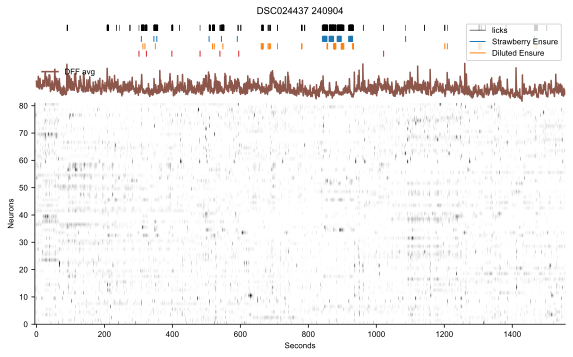

In [180]:
## plot without sorting

fig, axes = plt.subplots(figsize=[8,5],gridspec_kw={'height_ratios':[1.5,1.5,8],'hspace':0.0},nrows=3,sharex=True)

vmax=8 # cap the upper limit for color map
vmin=0.5
extent = [df_z.index[0],df_z.index[-1],0,df_z.shape[1]] # make the axis label readable
axes[2].imshow(df_z.T,aspect='auto',extent=extent,vmax=vmax,vmin=vmin,cmap='Greys',interpolation='none')

## plot pump events with with shift in y position
ymax = df_z.shape[1]
axes[0].eventplot(L1_timestamps_new,color=['k'],lineoffsets=4.5,linelengths=0.8,linewidths=0.5)
axes[0].eventplot([P1D_time,P1C_time,P1_time],lineoffsets=[3,2,1],color=['C0','C1','C3'],linelengths=0.8,linewidths=1)

axes[1].plot(df_z.mean(axis=1)[0:],color='C5',label='DFF avg',lw=1.5)
# axes[0].legend(['licks',flavor_dict['P1D'],flavor_dict['P1C'],flavor_dict['P1']],frameon=False,fontsize=6,loc=2)
axes[0].legend(['licks',flavor_dict['P1D'],flavor_dict['P1C']],frameon=True,fontsize=8)
axes[1].legend(frameon=False,loc=2)

axes[0].axis('off')
axes[1].axis('off')
axes[2].set_xlabel('Seconds')
axes[2].set_ylabel('Neurons')
axes[0].set_title(f"{mouse_id} {date}")
sns.despine(ax=axes[2])
plt.tight_layout()


0 this bout starts with P1C
1 this bout starts with P1C
2 this bout starts with P1D
3 this bout starts with P1D
4 this bout starts with P1D
5 this bout starts with P1D
6 this bout starts with P1C


             start       end
       0   661.483   667.164
       1   681.534   685.494
       2  1301.83   1304.8
shape: (3, 2), time unit: sec.

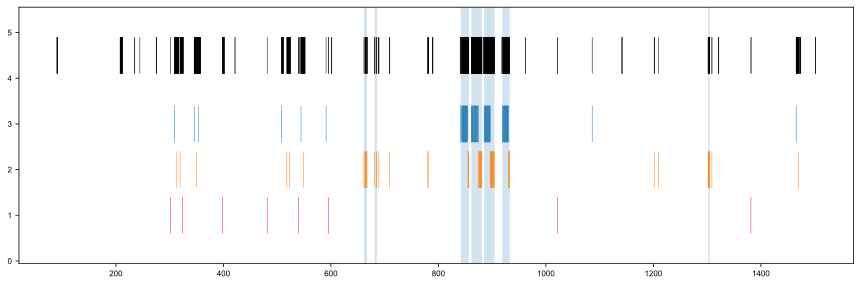

In [181]:
## run binge detection on P1D+P1C together, which will give us the overall feeding rate

interval = 3
binge_epoch, not_binge_epoch = [],[]

binge_df, binge_epoch = detect_binge_bout(Pump_event=P1D_P1C_time,
                            n_pumps = 3, # min of pump events in one binge bout  
                            max_isi = interval,
                            min_ibi = interval)
# binge_epoch

## function for converting intervalset to pandas dataframe
def intervalset2pd(intervalset):
    return pd.DataFrame(data=intervalset.values,columns=intervalset.columns)
def pd2intervalset(pd):
    return nap.IntervalSet(start=pd['start'].values,end=pd['end'].values)

# binge_epoch = intervalset2pd(binge_epoch)
# binge_epoch = pd.DataFrame(binge_epoch)
binge_epoch = binge_epoch.as_dataframe()

plt.figure(figsize=[12,4])
plt.eventplot(L1_timestamps_new,color=['k'],lineoffsets=4.5,linelengths=0.8,linewidths=0.5)
plt.eventplot([P1D_time,P1C_time,P1_time],lineoffsets=[3,2,1],color=['C0','C1','C3'],linelengths=0.8,linewidths=0.5)

for i in range(len(binge_epoch)):
    plt.axvspan(xmin=binge_epoch.start[i],xmax=binge_epoch.end[i],alpha=0.2)

# plt.xlim([620,700])
plt.tight_layout()

## now find which flavor it starts with

flavor_list = []

for i in range(len(binge_epoch)):
    if binge_epoch.start[i] in P1D_time:
        print(i, 'this bout starts with P1D')
        flavor_list.append('Ensure')
    elif binge_epoch.start[i] in P1C_time:
        print(i, 'this bout starts with P1C')
        flavor_list.append('Diluted Ensure')
    else:
        print(i, 'wrong, check if something is off')

binge_epoch['flavor'] = flavor_list

binge_epoch_P1D = binge_epoch[binge_epoch['flavor'] == 'Ensure']
binge_epoch_P1D = nap.IntervalSet(binge_epoch_P1D[['start','end']])
binge_epoch_P1D

binge_epoch_P1C = binge_epoch[binge_epoch['flavor'] == 'Diluted Ensure']
binge_epoch_P1C = nap.IntervalSet(binge_epoch_P1C[['start','end']])
binge_epoch_P1C

# plt.xlim([1397,1400])

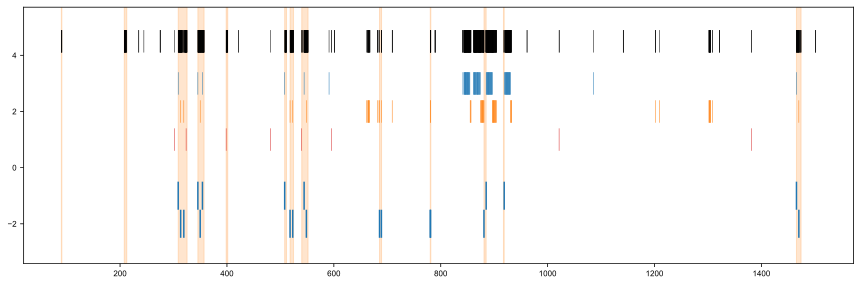

In [182]:
## take out binge bouts from pump events so we have only sloww feeding events left.

interval = 4
lick_df, lick_epoch = detect_binge_bout(Pump_event=L1_timestamps_new,
                                        n_pumps = 3, # min of pump events in one binge bout  
                                        max_isi = interval,
                                        min_ibi = interval)
binge_epoch
lick_epoch = lick_epoch.set_diff(pd2intervalset(binge_epoch))
## remove epoch smaller than 1 seconds?
lick_epoch = intervalset2pd(lick_epoch)
lick_epoch['duration'] = lick_epoch['end']- lick_epoch['start']
lick_epoch = lick_epoch[lick_epoch['duration']>1]
lick_epoch = pd2intervalset(lick_epoch)
lick_epoch

plt.figure(figsize=[12,4])
plt.eventplot(L1_timestamps_new,color=['k'],lineoffsets=4.5,linelengths=0.8,linewidths=0.5)
plt.eventplot([P1D_time,P1C_time,P1_time],lineoffsets=[3,2,1],color=['C0','C1','C3'],linelengths=0.8,linewidths=0.5)

for i in range(len(lick_epoch)):
    plt.axvspan(xmin=lick_epoch.start[i],xmax=lick_epoch.end[i],alpha=0.2,color='C1')

plt.eventplot(nap.Ts(P1D_time).restrict(lick_epoch).index,lineoffsets=-1) # this is ensure slow timestamps
plt.eventplot(nap.Ts(P1C_time).restrict(lick_epoch).index,lineoffsets=-2) # this is diluted ensure slow timestamps

plt.tight_layout()
# plt.xlim([650,750])

In [197]:

## get pump events only during slow feeding/licking epoch

P1D_slow_ts = nap.Ts(P1D_time).restrict(lick_epoch).index
P1C_slow_ts = nap.Ts(P1C_time).restrict(lick_epoch).index
P1_slow_ts  = nap.Ts(P1_time).restrict(lick_epoch).index

# remove trials where there is no lick events after pump delivery
P1D_slow_ts_clean  = slow_feeding_event_clean_up(slow_milk_ts=P1D_slow_ts, lick_event=L1_timestamps_new)
P1C_slow_ts_clean  = slow_feeding_event_clean_up(slow_milk_ts=P1C_slow_ts, lick_event=L1_timestamps_new)
P1_slow_ts_clean   = slow_feeding_event_clean_up(slow_milk_ts=P1_slow_ts, lick_event=L1_timestamps_new)

## compute peri-event with nap function

## functioo for align baseline for each trials
def align_peth(nap_peth,start=-1,end=0):
    data = nap_peth.values
    t = nap_peth.t
    data = nap_peth.copy().values
    t = nap_peth.t
    for cell in range(data.shape[2]):
        for trial in range(data.shape[1]):
            data[:,trial,cell] -= data[(t>start)&(t<end),trial,cell].mean(axis=0) # align baseline to 0 for each trial

    nap_peth_new = nap.TsdTensor(d=data,t=t)
    return nap_peth_new

correct_baseline_binary = True # set to False is you don't want to substract baseline from individual trials
aligned_window_start = -4 # the start time of the baseline you want to substract before the event onset 
aligned_window_end = 0 # the end time of the baseline you want to substract before the event onset 
# the current setting means you are finding the mean value of -4 to 0 seconds to the onset time and subtract this values for individual trials
minmax = (-10,10) # the time window you want to use compute PETH for.

if correct_baseline_binary:
    P1C_peth_nap           = align_peth(nap.compute_perievent_continuous(data=nap.TsdFrame(t=df_z.index,d=df_z.values), tref=nap.Ts(P1C_slow_ts_clean),minmax=minmax),    start=aligned_window_start,end=aligned_window_end)
    P1D_peth_nap           = align_peth(nap.compute_perievent_continuous(data=nap.TsdFrame(t=df_z.index,d=df_z.values), tref=nap.Ts(P1D_slow_ts_clean),minmax=minmax),    start=aligned_window_start,end=aligned_window_end)
    P1D_binge_peth_nap     = align_peth(nap.compute_perievent_continuous(data=nap.TsdFrame(t=df_z.index,d=df_z.values), tref=nap.Ts(binge_epoch_P1D.start),minmax=minmax),start=aligned_window_start,end=aligned_window_end)
    P1D_binge_peth_end_nap = align_peth(nap.compute_perievent_continuous(data=nap.TsdFrame(t=df_z.index,d=df_z.values), tref=nap.Ts(binge_epoch_P1D.end),minmax=minmax),  start=aligned_window_start,end=aligned_window_end)
    P1C_binge_peth_nap     = align_peth(nap.compute_perievent_continuous(data=nap.TsdFrame(t=df_z.index,d=df_z.values), tref=nap.Ts(binge_epoch_P1C.start),minmax=minmax),start=aligned_window_start,end=aligned_window_end)
    P1C_binge_peth_end_nap = align_peth(nap.compute_perievent_continuous(data=nap.TsdFrame(t=df_z.index,d=df_z.values), tref=nap.Ts(binge_epoch_P1C.end),minmax=minmax),  start=aligned_window_start,end=aligned_window_end)

else:
    P1C_peth_nap = nap.compute_perievent_continuous(data=nap.TsdFrame(t=df_z.index,d=df_z.values), tref=nap.Ts(P1C_slow_ts_clean),minmax=minmax)
    P1D_peth_nap = nap.compute_perievent_continuous(data=nap.TsdFrame(t=df_z.index,d=df_z.values), tref=nap.Ts(P1D_slow_ts_clean),minmax=minmax)
    P1D_binge_peth_nap = nap.compute_perievent_continuous(data=nap.TsdFrame(t=df_z.index,d=df_z.values), tref=nap.Ts(binge_epoch_P1D.start),minmax=minmax)
    P1D_binge_peth_end_nap = nap.compute_perievent_continuous(data=nap.TsdFrame(t=df_z.index,d=df_z.values), tref=nap.Ts(binge_epoch_P1D.end),minmax=minmax)
    P1C_binge_peth_nap     = nap.compute_perievent_continuous(data=nap.TsdFrame(t=df_z.index,d=df_z.values), tref=nap.Ts(binge_epoch_P1C.start),minmax=minmax)
    P1C_binge_peth_end_nap = nap.compute_perievent_continuous(data=nap.TsdFrame(t=df_z.index,d=df_z.values), tref=nap.Ts(binge_epoch_P1C.end),minmax=minmax)



In [198]:
## function for converting nap peth object to long data in pd.DataFrame for seaborn plotting

def nap_peth2longdf(nap_peth):
    if len(nap_peth.shape)==3:
        df_ = pd.DataFrame(nap_peth.d.mean(axis=1).T, columns=nap_peth.t)
    else:
        df_ = pd.DataFrame(nap_peth.d.T, columns=nap_peth.t)

    df_long = pd.melt(df_.reset_index(),id_vars='index',value_name='zs-dff',var_name='Time (sec)')
    return df_long


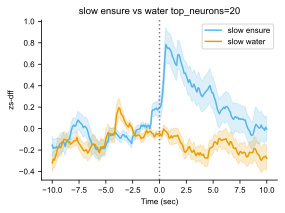

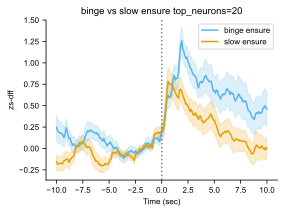

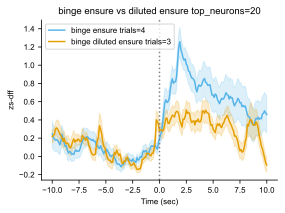

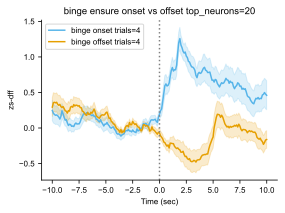

In [199]:
# i_sort = np.argsort(P1D_binge_peth_nap[50:90].mean(axis=(0,1)))
i_sort = np.argsort(-P1D_binge_peth_nap.values[100:150].mean(axis=(0,1)))

top_neurons = 20 # only for top neurons for binge ensure reponses
# top_neurons = P1D_binge_peth_nap.shape[2] # if for all neurons 

plt.figure(figsize=[4,3])
sns.lineplot(data = nap_peth2longdf(P1D_peth_nap[:,:,i_sort[:top_neurons]]), x='Time (sec)',y='zs-dff',errorbar='se',label='slow ensure',color=my_color_map[0])
sns.lineplot(data = nap_peth2longdf(P1C_peth_nap[:,:,i_sort[:top_neurons]]), x='Time (sec)',y='zs-dff',errorbar='se',label='slow water',color=my_color_map[1])
plt.axvline(x=0,color='grey',ls=':')
plt.title(f'slow ensure vs water {top_neurons=}')
sns.despine()
plt.tight_layout()
plt.show()
plt.figure(figsize=[4,3])
sns.lineplot(data = nap_peth2longdf(P1D_binge_peth_nap[:,:,i_sort[:top_neurons]]), x='Time (sec)',y='zs-dff',errorbar='se',label='binge ensure',color=my_color_map[0])
sns.lineplot(data = nap_peth2longdf(P1D_peth_nap[:,:,i_sort[:top_neurons]]), x='Time (sec)',y='zs-dff',errorbar='se',label='slow ensure',color=my_color_map[1])
plt.axvline(x=0,color='grey',ls=':')
sns.despine()
plt.title(f'binge vs slow ensure {top_neurons=}')
plt.tight_layout()

plt.figure(figsize=[4,3])
sns.lineplot(data = nap_peth2longdf(P1D_binge_peth_nap[:,:,i_sort[:top_neurons]]), x='Time (sec)',y='zs-dff',errorbar='se',label=f'binge ensure trials={P1D_binge_peth_nap.shape[1]}',color=my_color_map[0])
sns.lineplot(data = nap_peth2longdf(P1C_binge_peth_nap[:,:,i_sort[:top_neurons]]), x='Time (sec)',y='zs-dff',errorbar='se',label=f'binge diluted ensure trials={P1C_binge_peth_nap.shape[1]}',color=my_color_map[1])
plt.axvline(x=0,color='grey',ls=':')
sns.despine()
plt.title(f'binge ensure vs diluted ensure {top_neurons=}')
plt.tight_layout()


plt.figure(figsize=[4,3])
sns.lineplot(data = nap_peth2longdf(P1D_binge_peth_nap[:,:,i_sort[:top_neurons]]), x='Time (sec)',y='zs-dff',errorbar='se',label=f'binge onset trials={P1D_binge_peth_nap.shape[1]}',color=my_color_map[0])
sns.lineplot(data = nap_peth2longdf(P1D_binge_peth_end_nap[:,:,i_sort[:top_neurons]]), x='Time (sec)',y='zs-dff',errorbar='se',label=f'binge offset trials={P1D_binge_peth_end_nap.shape[1]}',color=my_color_map[1])
plt.axvline(x=0,ls=':',color='grey')
plt.title(f'binge ensure onset vs offset {top_neurons=}')
sns.despine()
plt.tight_layout()

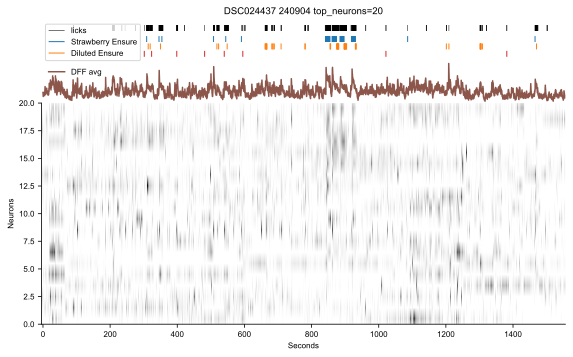

In [200]:
## plot the whole trace without sorting

fig, axes = plt.subplots(figsize=[8,5],gridspec_kw={'height_ratios':[1.5,1.5,8],'hspace':0.0},nrows=3,sharex=True)
top_neurons = 20
cell_id = i_sort[:top_neurons]

vmax=6.5 # cap the upper limit for color map
vmin=0
extent = [df_z.index[0],df_z.index[-1],0,len(cell_id)] # make the axis label readable
# axes[2].imshow(df_z[df_z.columns[isort]].T,aspect='auto',extent=extent,vmax=vmax,vmin=vmin,cmap='Greys',interpolation='none')
axes[2].imshow(df_z.T.iloc[cell_id],aspect='auto',extent=extent,vmax=vmax,vmin=vmin,cmap='Greys',interpolation='none')

## plot pump events with with shift in y position
ymax = df_z.shape[1]
axes[0].eventplot(L1_timestamps_new,color=['k'],lineoffsets=4.5,linelengths=0.8,linewidths=0.5)
axes[0].eventplot([P1D_time,P1C_time,P1_time],lineoffsets=[3,2,1],color=['C0','C1','C3'],linelengths=0.8,linewidths=1)

axes[1].plot(df_z.T.iloc[cell_id].T.mean(axis=1)[0:],color='C5',label='DFF avg',lw=1.5)
# axes[0].legend(['licks',flavor_dict['P1D'],flavor_dict['P1C'],flavor_dict['P1']],frameon=False,fontsize=6,loc=2)
axes[0].legend(['licks',flavor_dict['P1D'],flavor_dict['P1C']],frameon=True,fontsize=8,loc=2)
axes[1].legend(frameon=False,loc=2)

axes[0].axis('off')
axes[1].axis('off')
axes[2].set_xlabel('Seconds')
axes[2].set_ylabel('Neurons')
axes[0].set_title(f"{mouse_id} {date} {top_neurons=}")
sns.despine(ax=axes[2])
# plt.xlim([100,800])
plt.tight_layout()

In [201]:
## function for set up colorbar values so that white is at center and the the actual values are reflected by darkness of the red/blue

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))


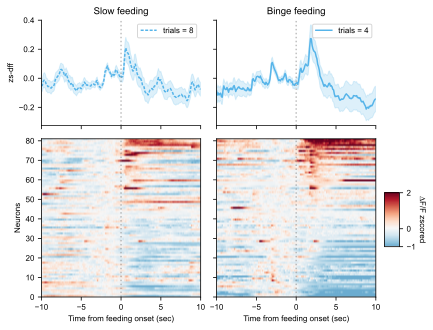

In [202]:
## plot average trace and heatmap of slow and binge feeding of all neurons with sorting

i_sort = np.argsort(-P1D_binge_peth_nap.values[100:150].mean(axis=(0,1)))

fig, axes = plt.subplots(nrows=2,ncols=2,figsize=[6,5],gridspec_kw={'height_ratios':[1,1.5],'hspace':0.1,'wspace':0.1},sharey='row',sharex=True)

extent = [-10,10,0,P1D_peth_nap.shape[2]]

vmin = -1
vmax = 2
midpoint = 0

norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

mx = axes[1,0].imshow(P1D_peth_nap.values[:,:,i_sort].mean(axis=1).T,aspect='auto',interpolation='none',extent=extent,norm=norm,cmap='RdBu_r')
axes[1,1].imshow(P1D_binge_peth_nap.values[:,:,i_sort].mean(axis=1).T,aspect='auto',interpolation='none',extent=extent,norm=norm,cmap='RdBu_r')

sns.lineplot(data=nap_peth2longdf(P1D_peth_nap[:,:,i_sort]),x='Time (sec)',y='zs-dff',ax=axes[0,0],label=f'trials = {P1D_peth_nap.shape[1]}',color=my_color_map[0],dashes=(2,1),errorbar='se')
sns.lineplot(data=nap_peth2longdf(P1D_binge_peth_nap[:,:,i_sort]),x='Time (sec)',y='zs-dff',ax=axes[0,1],label=f'trials = {P1D_binge_peth_nap.shape[1]}',color=my_color_map[0],errorbar='se')

sns.despine(ax=axes[0,0])
sns.despine(ax=axes[0,1])
axes[0,0].axvline(x=0,ls=':',color='grey',alpha=0.5)
axes[0,1].axvline(x=0,ls=':',color='grey',alpha=0.5)
axes[1,0].axvline(x=0,ls=':',color='grey',alpha=0.5)
axes[1,1].axvline(x=0,ls=':',color='grey',alpha=0.5)
# plt.xlim([-5,10])

axes[1,0].set_xlabel('Time from feeding onset (sec)')
axes[1,1].set_xlabel('Time from feeding onset (sec)')
axes[1,0].set_ylabel('Neurons')
axes[0,0].set_title('Slow feeding')
axes[0,1].set_title('Binge feeding')

## shrink fig and add color bar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.035, 0.15])
cbar_ax.get_yaxis().labelpad = 15
fig.colorbar(mx, cax=cbar_ax,ticks=[vmin,0,vmax])
cbar_ax.set_ylabel('∆F/F zscored', rotation=270,labelpad=10)

plt.tight_layout()


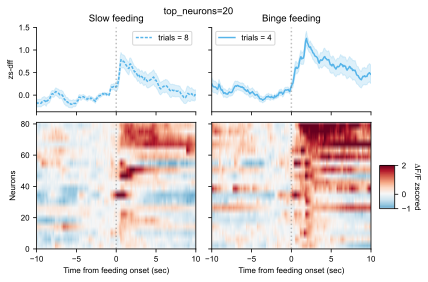

In [203]:
# plot average trace and heatmap of slow and binge feeding of all neurons with sorting
# plot only the select neurons (top x)

i_sort = np.argsort(-P1D_binge_peth_nap.values[100:150].mean(axis=(0,1)))
top_neurons = 20

fig, axes = plt.subplots(nrows=2,ncols=2,figsize=[6,4],gridspec_kw={'height_ratios':[1,1.5],'hspace':0.1,'wspace':0.1},sharey='row',sharex=True)

extent = [-10,10,0,P1D_peth_nap.shape[2]]

vmin = -1
vmax = 2
midpoint = 0

norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

mx = axes[1,0].imshow(P1D_peth_nap.values[:,:,i_sort[0:top_neurons]].mean(axis=1).T,aspect='auto',interpolation='none',extent=extent,norm=norm,cmap='RdBu_r')
axes[1,1].imshow(P1D_binge_peth_nap.values[:,:,i_sort[0:top_neurons]].mean(axis=1).T,aspect='auto',interpolation='none',extent=extent,norm=norm,cmap='RdBu_r')

sns.lineplot(data=nap_peth2longdf(P1D_peth_nap[:,:,i_sort[0:top_neurons]]),x='Time (sec)',y='zs-dff',ax=axes[0,0],label=f'trials = {P1D_peth_nap.shape[1]}',color=my_color_map[0],dashes=(2,1),errorbar='se')
sns.lineplot(data=nap_peth2longdf(P1D_binge_peth_nap[:,:,i_sort[0:top_neurons]]),x='Time (sec)',y='zs-dff',ax=axes[0,1],label=f'trials = {P1D_binge_peth_nap.shape[1]}',color=my_color_map[0],errorbar='se')

sns.despine(ax=axes[0,0])
sns.despine(ax=axes[0,1])
axes[0,0].axvline(x=0,ls=':',color='grey',alpha=0.5)
axes[0,1].axvline(x=0,ls=':',color='grey',alpha=0.5)
axes[1,0].axvline(x=0,ls=':',color='grey',alpha=0.5)
axes[1,1].axvline(x=0,ls=':',color='grey',alpha=0.5)
# plt.xlim([-5,10])

axes[1,0].set_xlabel('Time from feeding onset (sec)')
axes[1,1].set_xlabel('Time from feeding onset (sec)')
axes[1,0].set_ylabel('Neurons')
axes[0,0].set_title('Slow feeding')
axes[0,1].set_title('Binge feeding')

## shrink fig and add color bar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.035, 0.15])
cbar_ax.get_yaxis().labelpad = 15
fig.colorbar(mx, cax=cbar_ax,ticks=[vmin,0,vmax])
cbar_ax.set_ylabel('∆F/F zscored', rotation=270,labelpad=10)

fig.suptitle(f'{top_neurons=}',y=0.95)
plt.tight_layout()

In [210]:
## generate a matrix for timeseries k-means clustering

## if you want to take both responses from binge onset/offset and slow feeding ensure/water
X = np.concatenate([P1D_binge_peth_nap.values.mean(axis=1).T,
                    P1D_binge_peth_end_nap.values.mean(axis=1).T,
                    P1D_peth_nap.values.mean(axis=1).T,
                    P1C_peth_nap.values.mean(axis=1).T],
                    axis=1)
X.shape

## or if you only take binge responses
X = P1D_binge_peth_nap.values.mean(axis=1).T


In [211]:
## testing tslearn for k-means clustering

## currently 2 cluster seems to be optimal

from tslearn.clustering import TimeSeriesKMeans, silhouette_score

km = TimeSeriesKMeans(n_clusters=2)
labels = km.fit_predict(X)
print(silhouette_score(X, labels, metric="euclidean"))  # a score for how well the clustering is, you can do this with different cluster size, and then choose the largeest value.

## swap the order if cluster 1 has more neurons than cluster 0, not a necessary step
if sum(labels==1)<sum(labels==0):
    print('swap')
    labels = [0 if i == 1 else 1 for i in labels]


0.5386237141564358
swap


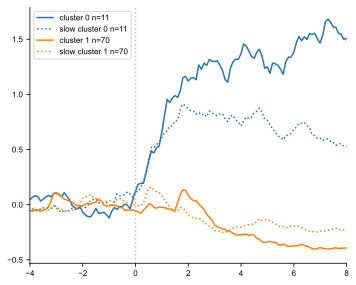

In [212]:
plt.figure(figsize=[5,4])

cluster_dict = {}
for i in set(labels):
    cluster_dict[i] = [idx for idx in range(len(labels)) if labels[idx]==i]
    # plt.plot(X[cluster_dict[i]].mean(axis=0),label=f'cluster {i} n={len(cluster_dict[i])}',color=f'C{i}')
    plt.plot(P1D_binge_peth_nap.t,P1D_binge_peth_nap.values.mean(axis=1).T[cluster_dict[i]].mean(axis=0),label=f'cluster {i} n={len(cluster_dict[i])}',color=f'C{i}')
    plt.plot(P1D_binge_peth_nap.t,P1D_peth_nap.values.mean(axis=1).T[cluster_dict[i]].mean(axis=0),label=f'slow cluster {i} n={len(cluster_dict[i])}',color=f'C{i}',ls=':')
plt.legend()
plt.xlim(xmin=-4,xmax=8)
plt.axvline(x=0,color='grey',ls=':',alpha=0.5)
sns.despine()
plt.tight_layout()


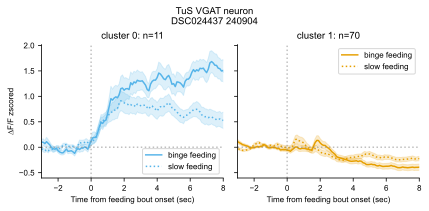

In [213]:
fig, axes = plt.subplots(ncols=2,figsize=[6,3],sharex=True,sharey=True)

for cluster_idx in cluster_dict.keys():
    sns.lineplot(nap_peth2longdf(P1D_binge_peth_nap[:,:,cluster_dict[cluster_idx]]),x='Time (sec)',y='zs-dff',errorbar='se',label=f'binge feeding',color=my_color_map[cluster_idx],ax=axes[cluster_idx])
    sns.lineplot(nap_peth2longdf(P1D_peth_nap[:,:,cluster_dict[cluster_idx]]),x='Time (sec)',y='zs-dff',errorbar='se',label=f'slow feeding',color=my_color_map[cluster_idx],ax=axes[cluster_idx],ls=':')
    
    axes[cluster_idx].set_title(f'cluster {cluster_idx}: n={len(cluster_dict[cluster_idx])}')
    axes[cluster_idx].axvline(x=0,color='grey',ls=':',alpha=0.5)
    axes[cluster_idx].axhline(y=0,color='grey',ls=':',alpha=0.5)
    sns.despine(ax=axes[cluster_idx])
    axes[cluster_idx].set_xlabel('Time from feeding bout onset (sec)')

axes[0].set_ylabel('∆F/F zscored')
plt.xlim(xmin=-3,xmax=8)
fig.suptitle(f'TuS VGAT neuron\n{mouse_id} {date}',y=0.95)
plt.tight_layout()


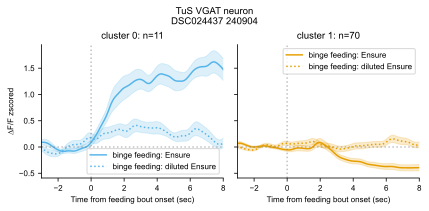

In [214]:
fig, axes = plt.subplots(ncols=2,figsize=[6,3],sharex=True,sharey=True)

for cluster_idx in cluster_dict.keys():
    sns.lineplot(nap_peth2longdf(P1D_binge_peth_nap.smooth(std=0.2)[:,:,cluster_dict[cluster_idx]]),x='Time (sec)',y='zs-dff',errorbar='se',label=f'binge feeding: Ensure',color=my_color_map[cluster_idx],ax=axes[cluster_idx])
    sns.lineplot(nap_peth2longdf(P1C_binge_peth_nap.smooth(std=0.2)[:,:,cluster_dict[cluster_idx]]),x='Time (sec)',y='zs-dff',errorbar='se',label=f'binge feeding: diluted Ensure',color=my_color_map[cluster_idx],ax=axes[cluster_idx],ls=':')
    
    axes[cluster_idx].set_title(f'cluster {cluster_idx}: n={len(cluster_dict[cluster_idx])}')
    axes[cluster_idx].axvline(x=0,color='grey',ls=':',alpha=0.5)
    axes[cluster_idx].axhline(y=0,color='grey',ls=':',alpha=0.5)
    sns.despine(ax=axes[cluster_idx])
    axes[cluster_idx].set_xlabel('Time from feeding bout onset (sec)')

axes[0].set_ylabel('∆F/F zscored')
plt.xlim(xmin=-3,xmax=8)
fig.suptitle(f'TuS VGAT neuron\n{mouse_id} {date}',y=0.95)
plt.tight_layout()
